In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import json
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from typing import List
from base import Scene
from PIL import Image

np.set_printoptions(suppress=True)
# %matplotlib ipympl

In [3]:
import torch
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from torchvision.models import resnet18, ResNet18_Weights

config_file = '../../Projects/mmdetection/configs/swin/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco.py'
checkpoint_file = '../../Projects/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco_20210908_165006-90a4008c.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

weights = ResNet18_Weights.IMAGENET1K_V1
resnet = resnet18(weights=weights)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.eval().cuda()
preprocess = weights.transforms()


load checkpoint from local path: ../../Projects/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco_20210908_165006-90a4008c.pth


In [5]:
folder_dir = 'C:/Users/Leonard/AppData/LocalLow/DefaultCompany/Perception2/solo_3'
# folder_dir = 'C:/Users/Leonard/AppData/LocalLow/DefaultCompany/Perception2/solo_6'
# folder_dir = './data/solo/'

errs = []
for i in range(20):
    f_dir = f'{folder_dir}/sequence.{i}'
    with open(f'{f_dir}/step0.frame_data.json') as json_file:
        data = json.load(json_file)
    captures = data['captures']

    scene = Scene.from_captures(f_dir, captures, model, resnet, preprocess)

    
    break
# print(np.mean(errs))

In [22]:
for camera in scene.cameras:
    img = Image.open(camera.filename)
    for bbox in camera.gt_bboxes:
        # bbox = pred[0]
        tl, br = bbox.center - bbox.size, bbox.center + bbox.size
        crop = img.crop((*tl, *br))
        plt.imshow(crop)
        plt.axis('off')
        plt.show()

TypeError: 'BoundingBox' object is not subscriptable

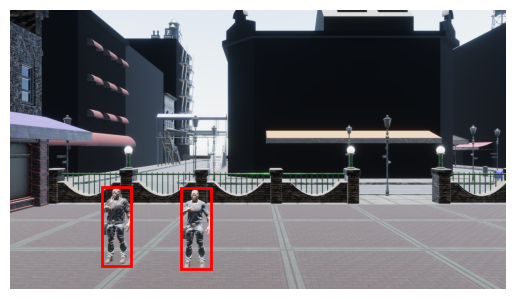

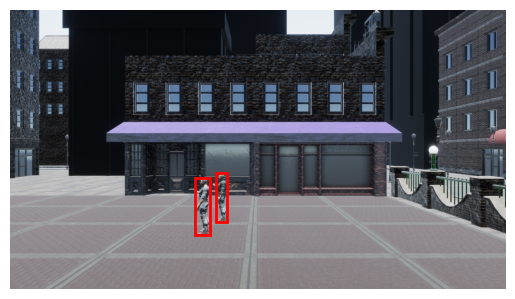

In [16]:
scene.show_pred_bboxes()

In [ ]:
camera_coor = [
    np.array([0, 0, 15]),
    np.array([3, 0, 15]),
    np.array([0, 3, 15]),
    np.array([3, 3, 15]),
]

focal = 20.78461
resolution = np.array([3840, 2160])
sensor = np.array([30, 30])
intrinsic = np.array([
    [focal*resolution[0]/sensor[0], 0, 0],
    [0, -focal*resolution[0]/sensor[0], 0],
    [resolution[0]/2, resolution[1]/2, 1],
])
ndc_coor = [np.matmul(coor, intrinsic) for coor in camera_coor]

pixel_coor = [np.floor((coor/coor[-1])[:-1]) for coor in ndc_coor]
for coor_a, coor_b in zip(pixel_coor, ndc_coor):
    print(coor_a, "|", coor_b/coor_b[-1])

In [ ]:
def camera_to_world(pixel_coor):
    homo_coor = [np.insert(coor, 2, 1) for coor in pixel_coor]

    coor = [np.matmul(coor, np.linalg.inv(intrinsic)) for coor in homo_coor]

    return coor

coors = camera_to_world(pixel_coor)
for coor in coors:
    print(coor)


In [ ]:
def qm(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    
    return np.array([
        -x1*x0 - y1*y0 - z1*z0 + w1*w0,
         x1*w0 - y1*z0 + z1*y0 + w1*x0,
         x1*z0 + y1*w0 - z1*x0 + w1*y0,
        -x1*y0 + y1*x0 + z1*w0 + w1*z0
    ])

q = np.array([0, 1, 0, 0])
abc = [
    np.array([0, 2, 1.5, 0]),
]
d = np.array([2, 2, 5])

_inv = np.array([1, -1, -1, -1])
print(
    qm(qm(q, abc[0]), q*_inv), qm(qm(q, abc[0]), q*_inv)[1:] - d
)